In [1]:
import pymc as pm
import arviz as az

import numpy as np

In [2]:
with pm.Model() as regularity_model1:
    # determine the regularity
    regularity = 0.1
    for i in range(10): # generate 10 patterns
        for beat in range(1,4): # beats 2-4
            # sample each beat in each pattern
            pm.Bernoulli(f"pattern{i}_b{beat}", regularity)

    output1 = pm.sample_prior_predictive(1)

Sampling: [pattern0_b1, pattern0_b2, pattern0_b3, pattern1_b1, pattern1_b2, pattern1_b3, pattern2_b1, pattern2_b2, pattern2_b3, pattern3_b1, pattern3_b2, pattern3_b3, pattern4_b1, pattern4_b2, pattern4_b3, pattern5_b1, pattern5_b2, pattern5_b3, pattern6_b1, pattern6_b2, pattern6_b3, pattern7_b1, pattern7_b2, pattern7_b3, pattern8_b1, pattern8_b2, pattern8_b3, pattern9_b1, pattern9_b2, pattern9_b3]


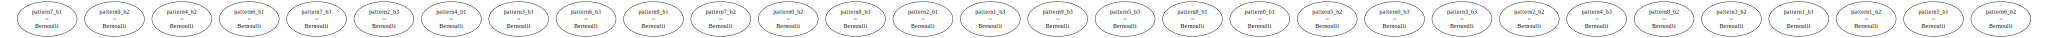

In [3]:
pm.model_to_graphviz(regularity_model1)

In [4]:
output1

Inference data with groups:
	> prior

In [5]:
coords = {
    "patterns": range(10),
    "beats": ["beat2", "beat3", "beat4"]
}

In [6]:
with pm.Model(coords=coords) as regularity_model2:
    # determine the regularity
    regularity = 0.1
    for i in range(10): # generate 10 patterns
        # sample all beats in this pattern
        pm.Bernoulli(f"pattern{i}", regularity, dims="beats")

    output2 = pm.sample_prior_predictive(1)

Sampling: [pattern0, pattern1, pattern2, pattern3, pattern4, pattern5, pattern6, pattern7, pattern8, pattern9]


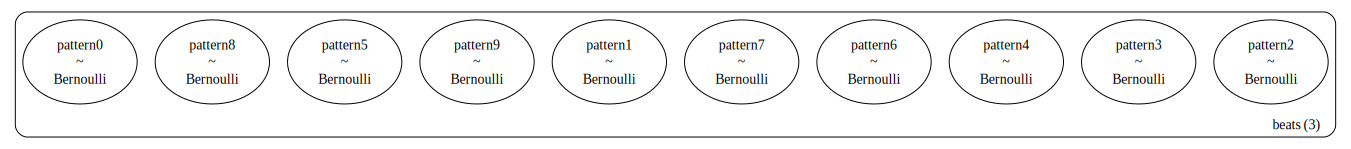

In [7]:
pm.model_to_graphviz(regularity_model2)

In [8]:
output2

Inference data with groups:
	> prior

In [9]:
with pm.Model(coords=coords) as regularity_model3:
    # determine the regularity
    regularity = 0.9
    # sample patterns
    pm.Bernoulli(f"repeat", regularity, dims=["patterns", "beats"])

    output3 = pm.sample_prior_predictive(1)

for pattern in output3.prior.repeat.sel(chain=0, draw=0):
    pstr = "".join(np.array(["n", "r"])[pattern.to_numpy()])
    print(f"*{pstr}")

Sampling: [repeat]


*rrr
*nrr
*rrr
*rrr
*rrr
*rrn
*rrn
*rrr
*rrr
*rrr


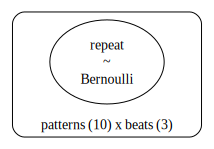

In [10]:
pm.model_to_graphviz(regularity_model3)

In [11]:
output3

Inference data with groups:
	> prior

In [12]:
output3.prior.repeat.sel(chain=0, draw=0, beats="beat2")

<xarray.DataArray 'repeat' (patterns: 10)>
array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
    chain     int64 0
    draw      int64 0
  * patterns  (patterns) int64 0 1 2 3 4 5 6 7 8 9
    beats     <U5 'beat2'

In [13]:
data_group1 = np.array([
    [1, 1, 1], # pattern 1: *rrr
    [0, 0, 0], # pattern 2: *nnn
    [1, 0, 1], # pattern 3: *rnr
])
data_group1

array([[1, 1, 1],
       [0, 0, 0],
       [1, 0, 1]])

In [14]:
data_group2 = np.array([
    [0, 0, 0], # pattern 1: *rrr
    [0, 0, 0], # pattern 2: *nnn
    [0, 1, 0], # pattern 3: *rnr
])
data_group2

array([[0, 0, 0],
       [0, 0, 0],
       [0, 1, 0]])

In [15]:
def run_inference(data):
    coords = {
        "patterns": range(data.shape[0]),
        "beats": ["beat2", "beat3", "beat4"]
    }
    with pm.Model(coords=coords) as regularity_model_inference:
        # determine the regularity
        regularity = pm.Beta("regularity", 0.5, 0.5)
        # sample patterns
        pm.Bernoulli(f"repeat", regularity, dims=["patterns", "beats"], observed=data)
    
        idata = pm.sample(4000)
    return idata, regularity_model_inference

In [16]:
output_g1, model = run_inference(data_group1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [regularity]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2 seconds.


In [17]:
output_g1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

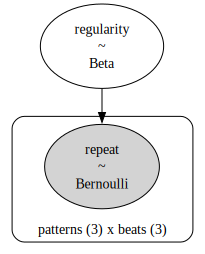

In [18]:
pm.model_to_graphviz(model)

<Axes: title={'center': 'regularity'}>

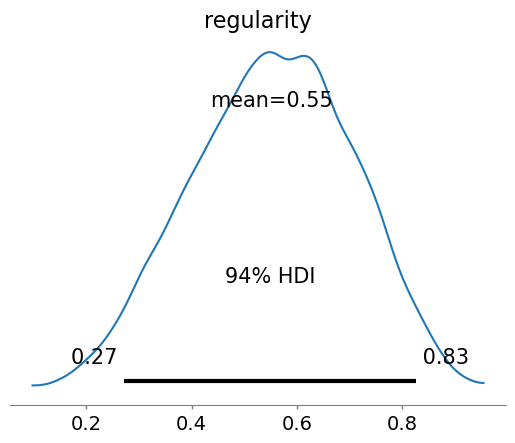

In [19]:
az.plot_posterior(output_g1)

In [22]:
output_g2, _ = run_inference(data_group2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [regularity]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2 seconds.


<Axes: title={'center': 'regularity'}>

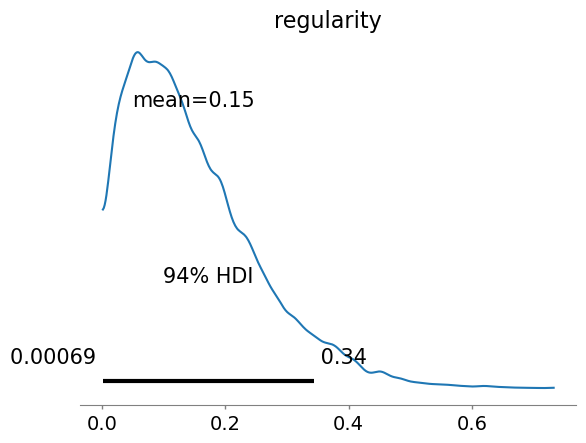

In [23]:
az.plot_posterior(output_g2)